# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

all_sw = stopwords.words('spanish')

In [2]:
df = pd.read_csv("Datathon 2024 - Reto Hey - Dataset Público - Sheet1.csv")
df['tweet'].iloc[7]

'Muchas gracias 😊'

## Wordcloud

### Removing Emojis

In [3]:
# Removing emojis as first attempt to create wordloud

def remove_emojis(text):
    return emoji.replace_emoji(text, '')

def emoji_to_text(text):
    return emoji.demojize(text)

def remove_stopwords(text):
    words = word_tokenize(text, language='spanish')
    return ' '.join([word.lower() for word in words if word.lower() not in all_sw])

def clean_text(df, emoji='remove', strip=True, sw=True):
    df1 = df.copy()
    if emoji == 'remove':
        df1['clean_tweet'] = df1['tweet'].apply(remove_emojis)
    elif emoji == 'text':
        df1['clean_tweet'] = df1['tweet'].apply(emoji_to_text)
    
    if strip:
        df1['clean_tweet'] = df1['clean_tweet'].str.rstrip()
        df1['clean_tweet'] = df1['clean_tweet'].str.replace(r'\s+', ' ', regex=True).str.strip()

    if sw:
        df1['clean_tweet'] = df1['clean_tweet'].apply(remove_stopwords)
    return df1

In [4]:
df1 = clean_text(df)
df1['clean_tweet'].iloc[7]

'muchas gracias'

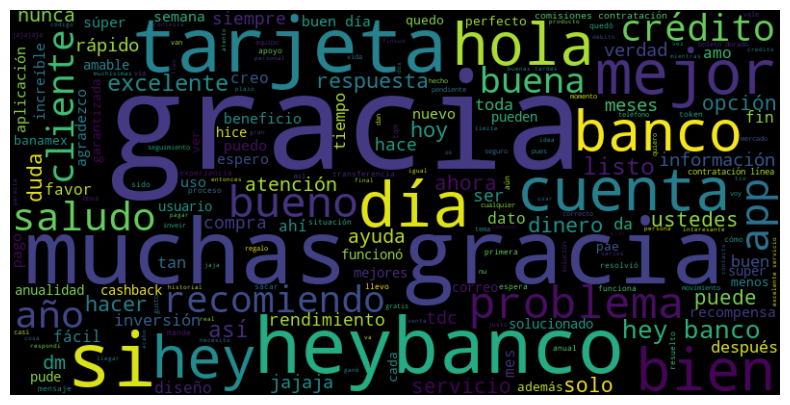

In [6]:
# Join all text in one string
text = ' '.join(df1['clean_tweet'].tolist())

# Wordcloud
wc = wordcloud.WordCloud(width=800, height=400).generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### New stopwords

In [7]:
new_sw = ['heybanco', 'muchas', 'mucha', 'gracia', 'gracias', 'hola', 'día', 'si', 'tarjeta', 'listo', 'hey',
          'banco', 'tan', 'hace', 'solo', 'favor', 'ahora', 'así', 'días']
all_sw = list(all_sw) + new_sw

df2 = clean_text(df1, emoji='remove', strip=False)

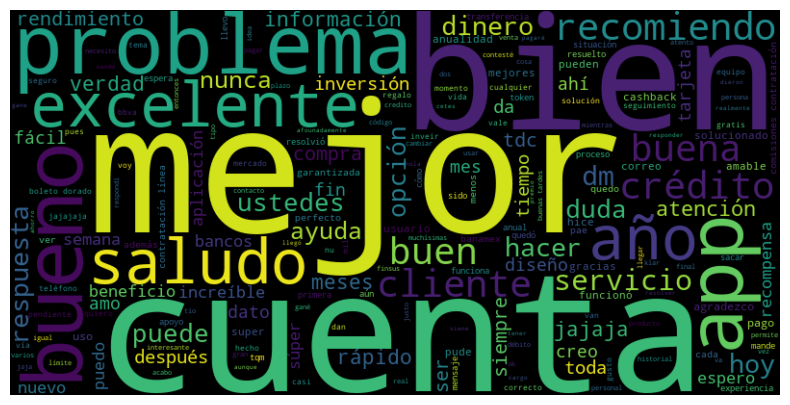

In [8]:
# Join all text in one string
text = ' '.join(df2['clean_tweet'].tolist())

# Wordcloud
wc = wordcloud.WordCloud(width=800, height=400).generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### With Emojis

In [9]:
df3 = clean_text(df1, emoji='text')
df3['clean_tweet'].iloc[7]

': smiling_face_with_smiling_eyes :'

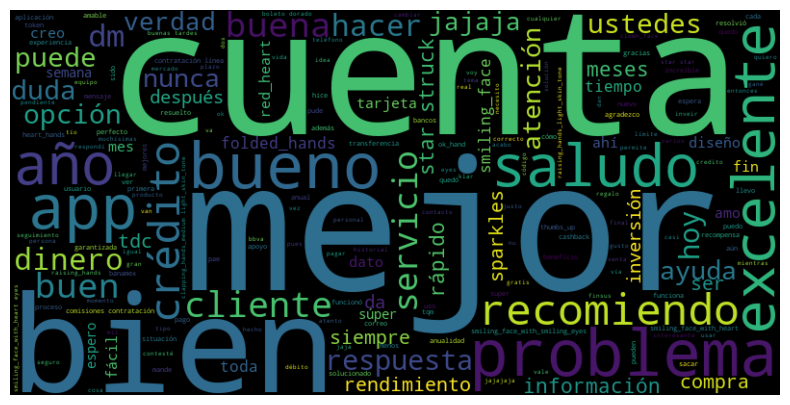

In [10]:
# Join all text in one string
text = ' '.join(df3['clean_tweet'].tolist())

# Wordcloud
wc = wordcloud.WordCloud(width=800, height=400).generate(text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Machine Learning

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [12]:
# TFIDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_sw, ngram_range=(1,2))
X = tfidf_vectorizer.fit_transform(df2['clean_tweet'])

# Clustering
number_of_clusters = 4
kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', max_iter=100, n_init=1, random_state=0)
kmeans.fit(X)

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(number_of_clusters):
    print('Cluster %d: ' %i),
for ind in order_centroids[i, :10]:
    print(' %s' % terms[ind])

Cluster 0: 
Cluster 1: 
Cluster 2: 
Cluster 3: 
 mejor
 bien
 saludos
 quedó
 jajaja
 recomiendo
 bueno
 buen
 ayuda
 problema


WordCloud for cluster 1


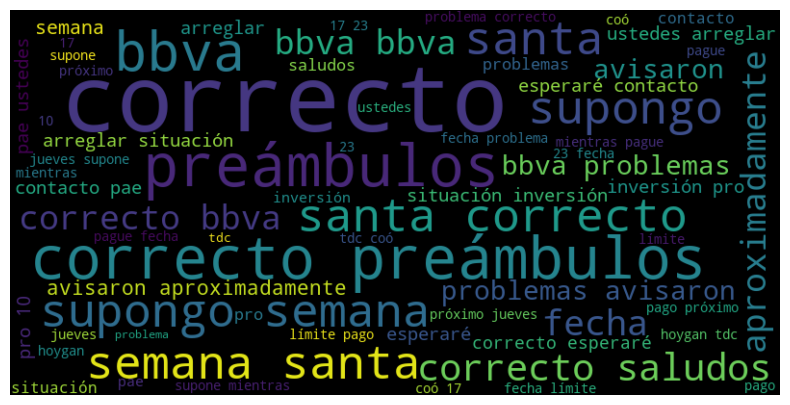

WordCloud for cluster 2


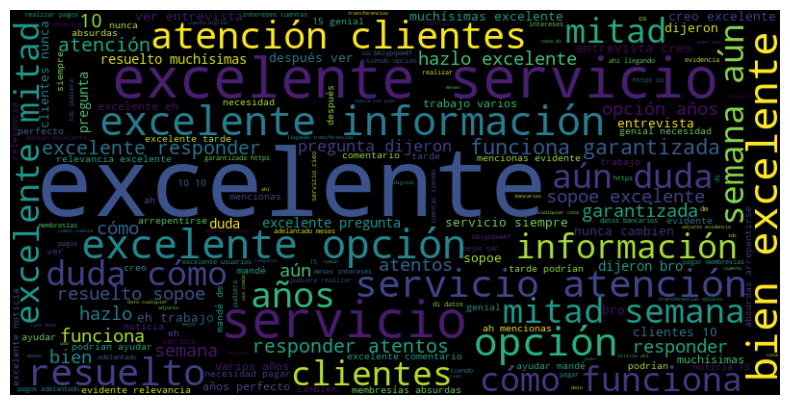

WordCloud for cluster 3


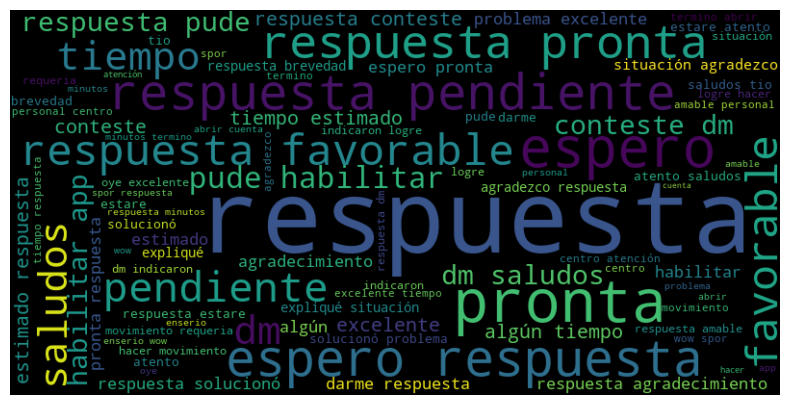

WordCloud for cluster 4


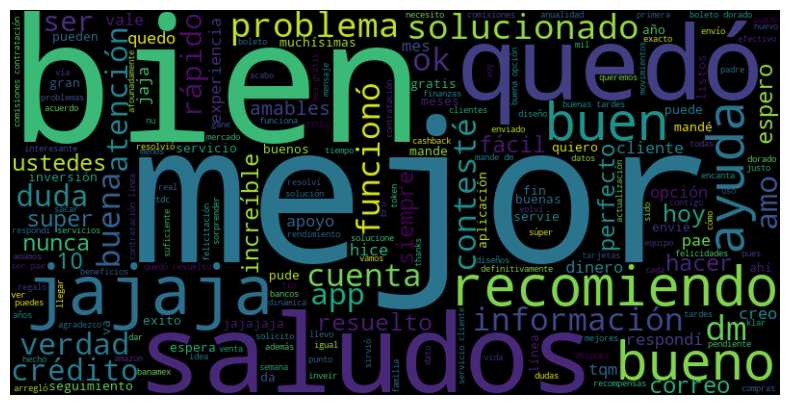

In [13]:
# Crear una función para generar WordClouds para cada cluster
def generate_wordclouds(cluster_model, terms):
    # Número de clusters
    n_clusters = cluster_model.n_clusters
    order_centroids = cluster_model.cluster_centers_.argsort()[:, ::-1]
    
    for i in range(n_clusters):
        print(f"WordCloud for cluster {i+1}")
        terms_freq = {}
        for ind in order_centroids[i, :]:  # Tomamos los top 10 términos de cada cluster
            terms_freq[terms[ind]] = cluster_model.cluster_centers_[i, ind]
        
        # Crear el WordCloud
        wc = wordcloud.WordCloud(width=800, height=400).generate_from_frequencies(terms_freq)
        
        # Visualización
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.show()

generate_wordclouds(kmeans, terms)